In [6]:
# Python packages (Install using pip install packagename)
import numpy as np
import pandas as pd
import os
import skimage
import skimage.transform as transform
from zipfile import ZipFile
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data was obtained from the Belgium Traffic Sign Dataset repository

In [7]:
# Data comes zipped and must be extracted first
data_dir = "data/"
os.listdir(data_dir)

['BelgiumTSC_Testing.zip', 'BelgiumTSC_Training.zip']

In [23]:
# Below both the training and testing data are extracted into the directory
with ZipFile("data/BelgiumTSC_Training.zip", "r") as f:
    training = f.extractall()
    
with ZipFile("data/BelgiumTSC_Testing.zip", "r") as f:
    testing = f.extractall()

In [8]:
def load_data(data_directory):

    """
    This function loads in the data for the Belgium Traffic sign dataset. Loading in the data makes use of the python os package.
    If not already enabled use: "import os"
    
    Somehow it still prevents me from using the external os function (seperated namespace?)
    
    """
    
    directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]
    
    labels = []
    images = []
    
    for d in directories:
    
        label_directory = str(str(os.getcwd()) + '\\' + data_directory + '\\'  + str(d)).split('\\')
        
        label_directory = '/'.join(label_directory)
        
        file_names = [os.path.join(label_directory, f) for f in os.listdir(label_directory) if f.endswith(".ppm")]
        
        for f in file_names:
            
            images.append(skimage.data.load(f))
            
            labels.append(int(d))
            
    return images, labels

In [9]:
training_imgs, training_labels = load_data("Training")
testing_imgs, testing_labels = load_data("Testing")

C:\Users\patri\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: This function is deprecated and will be removed in 0.18. Use `skimage.io.load` or `imageio.imread` directly.


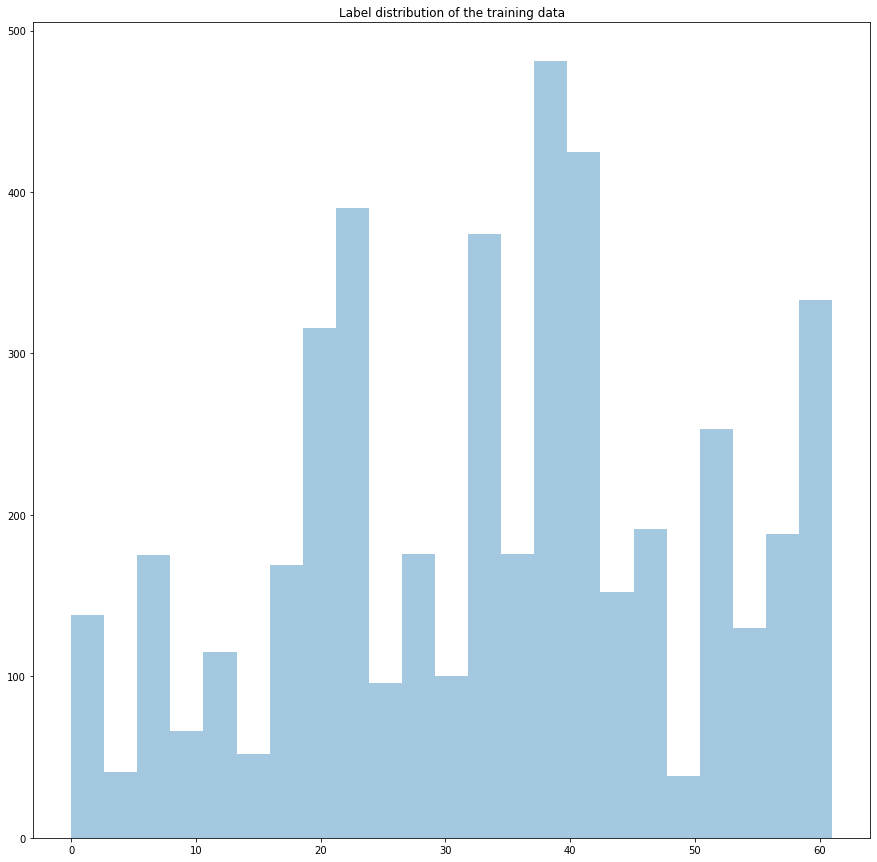

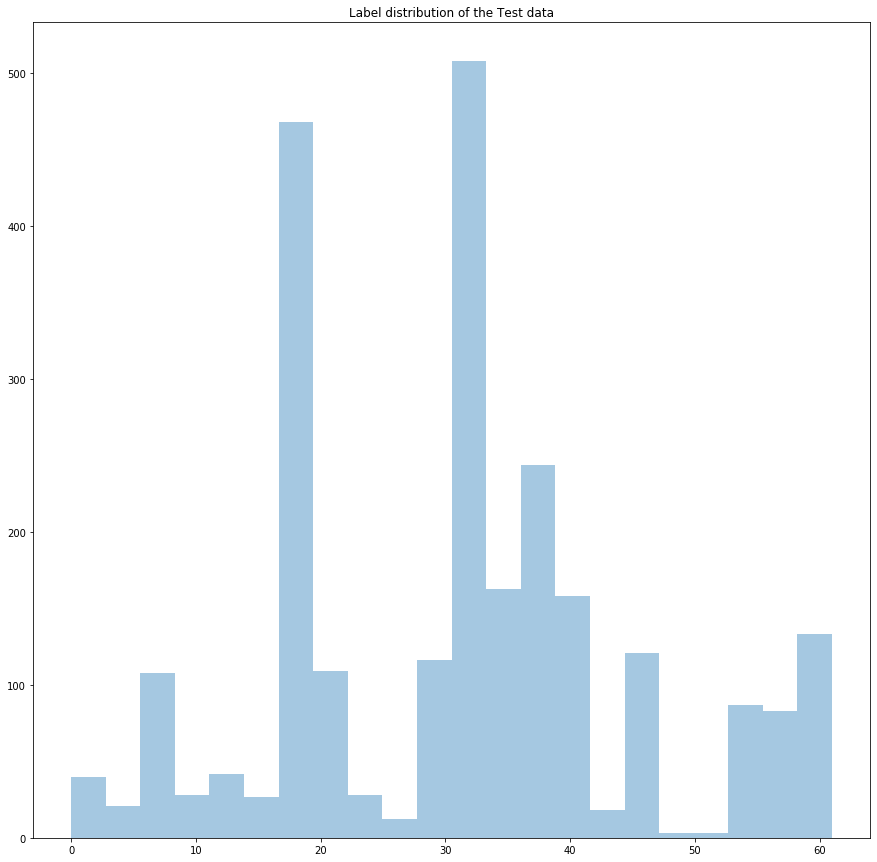

In [10]:
# Plot the distribution of the training data. This is important to do to identify potential class imbalances in the training data
plt.figure(figsize = (15, 15))
sns.distplot(training_labels, kde = False)
plt.title("Label distribution of the training data")
plt.show()

plt.figure(figsize = (15, 15))
sns.distplot(testing_labels, kde = False)
plt.title("Label distribution of the Test data")
plt.show()

There is obviously a clear imbalance in the distribution of labels in both the training and testing data set. This might have a huge impact on the performance of the model if not adressed properly. For now we will first preprocess the images themselves.

## Plotting Traffic signs

Below we will plot one of each label type.

In [11]:
def plot_image_list(img_list, figsize = (50, 50), cols = 10):
    
    plt.figure(figsize = figsize)
    
    rows = len(img_list)
    
    i = 1
    for image in img_list:
        plt.subplot(rows, cols, i)
        plt.imshow(image)
        i += 1
        
    plt.show()

In [12]:
current_label = 0

to_plot = []

for position, label in enumerate(training_labels):
    
    if label == current_label:
        to_plot.append(training_imgs[position])
        current_label += 1

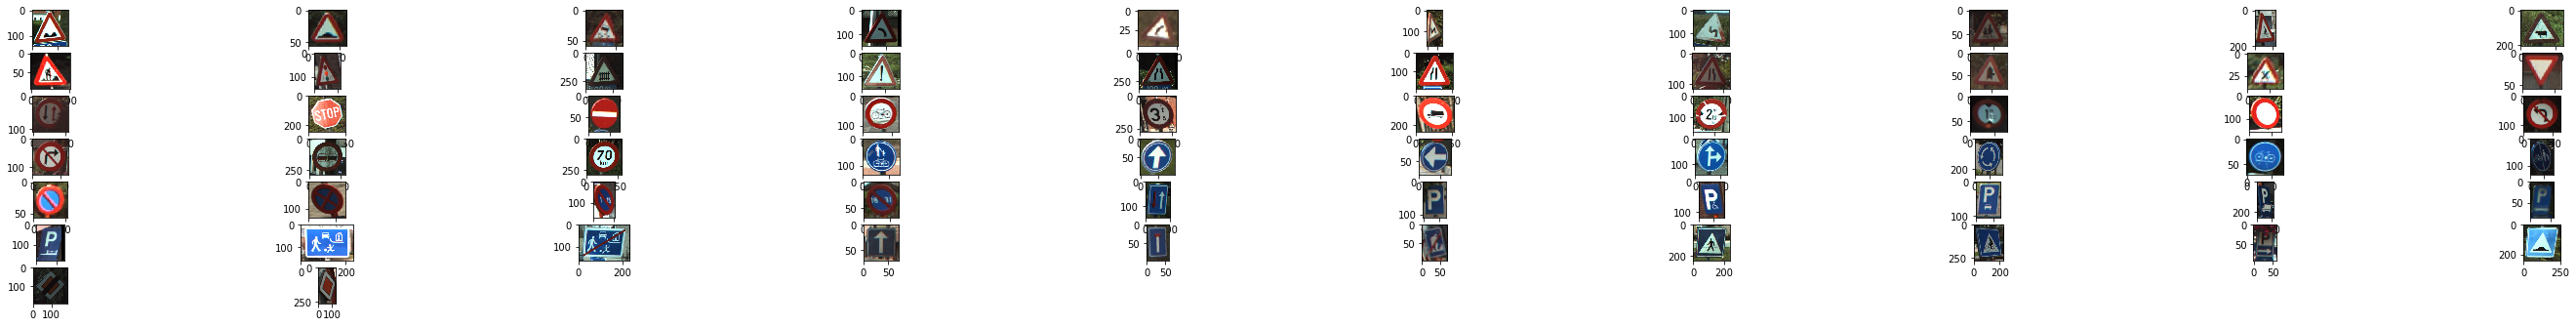

In [13]:
plot_image_list(to_plot)

The ouput size is not as desired, likely has something to do with the plt.subplot -> plt.subplots (should use that function instead).

Looking at the image we can see that the images do not have the same shape, this is an issue. Like all (I do not know exceptions at the moment and doubt that there are) ML and NN approaches a constant input size is required, and thus we must resize all images to a single size. The size should not be to large as the model will either use all memeory and crash or simply take way to long for a task that could be performed both faster and more efficient.

The choice of resizing the image to 28 x 28 is inspired from the Kaggle course on CNN's. The resizing will be performed using the skimage.transform.resize function

In [14]:
resized_training, resized_testing = [], []

for image in training_imgs:
    
    resized_training.append(transform.resize(image, (28, 28, 3)))
    
resized_training = np.array(resized_training)


for image in testing_imgs:
    
    resized_testing.append(transform.resize(image, (28, 28, 3)))
    
    
resized_testing = np.array(resized_testing)

In [15]:
x = resized_training

In [53]:
resized_testing.shape

(2520, 28, 28, 3)

In [16]:
unique_label = np.unique(training_labels)

y = np.empty((len(training_labels), len(unique_label)))

for sample, label in enumerate(training_labels):
    
    y[sample, label] = 1
    
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## The first model

In [59]:
first_model = Sequential()
first_model.add(Conv2D(50, kernel_size = (3, 3), activation = "relu", input_shape = (28, 28, 3)))
first_model.add(Dropout(0.50))
first_model.add(Conv2D(50, kernel_size = (3, 3), activation = "relu"))
first_model.add(Dropout(0.50))
first_model.add(Flatten())
first_model.add(Dense(128, activation = "relu"))
first_model.add(Dense(62, activation = "softmax"))

first_model.compile(loss = keras.losses.categorical_crossentropy, optimizer = "adam", metrics = ["accuracy"])

first_model.fit(x, y, batch_size = 305, epochs = 30, validation_split = 0.2)

Train on 3660 samples, validate on 915 samples
Epoch 1/30
3660/3660 [==============================] - 13s 4ms/sample - loss: 3.0797 - accuracy: 0.3311 - val_loss: 6.7876 - val_accuracy: 0.0000e+00
Epoch 2/30
3660/3660 [==============================] - 13s 4ms/sample - loss: 1.7977 - accuracy: 0.5948 - val_loss: 11.6367 - val_accuracy: 0.0000e+00
Epoch 3/30
3660/3660 [==============================] - 14s 4ms/sample - loss: 1.0341 - accuracy: 0.7792 - val_loss: 16.2325 - val_accuracy: 0.0000e+00
Epoch 4/30
3660/3660 [==============================] - 12s 3ms/sample - loss: 0.5956 - accuracy: 0.8604 - val_loss: 20.0304 - val_accuracy: 0.0000e+00
Epoch 5/30
3660/3660 [==============================] - 11s 3ms/sample - loss: 0.3580 - accuracy: 0.9128 - val_loss: 23.8820 - val_accuracy: 0.0000e+00
Epoch 6/30
3660/3660 [==============================] - 11s 3ms/sample - loss: 0.2347 - accuracy: 0.9372 - val_loss: 25.1093 - val_accuracy: 0.0000e+00
Epoch 7/30
3660/3660 [====================

# SVM approach

several sources mention that SVM s can obtain predictive capabilities that rival deep learning approaches. Below sklearns SVC() apporach will be used to create a classifier for the pictures as well. Note that the input matrix needs to be remodelled to some extent to be accepted as viable.

In [59]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict

In [55]:
svm_way_train = resized_training.reshape(4575, 28 *28 * 3)
svm_way_test = resized_testing.reshape(2520, 28 * 28 * 3)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(svm_way, training_labels, random_state = 0)

In [48]:
X_train.shape

(3431, 2352)

In [49]:
svm = SVC()
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
y_pred = svm.predict(X_test)

In [51]:
svm.score(X_test, y_test)

0.8601398601398601

In [56]:
svm.score(svm_way_test, testing_labels)

0.7829365079365079

Initial predictions using the default SVC settings seems to be rather promising. Tuning of the hyperparametes might improve the predictive power of this approach.

In [57]:
for kernel in ["linear", "sigmoid", "rbf", "poly"]:
    
    svm = SVC(kernel = kernel)
    svm.fit(X_train, y_train)

    print(svm.score(X_test, y_test))
    print(svm.score(svm_way_test, testing_labels))

0.9571678321678322
0.8702380952380953
0.13898601398601398
0.16031746031746033
0.8601398601398601
0.7829365079365079
0.8592657342657343
0.7214285714285714


Changing the SVM kernel function seems to have some impact. The default kernel (RBF kernel a.k.a. the radial basis fucntion kernel) already performs rather well, yet the linear kernel, as mentioned in some sources seems to perform better(source).

In [58]:
for regulizer in [1.0, 0.95, 0.90, 0.85, 0.80, 0.75]:
    
    svm = SVC(C = regulizer, kernel = "linear")
    svm.fit(X_train, y_train)

    print(svm.score(X_test, y_test))
    print(svm.score(svm_way_test, testing_labels))

0.9571678321678322
0.8702380952380953
0.9571678321678322
0.8702380952380953
0.9571678321678322
0.8702380952380953
0.9571678321678322
0.8702380952380953
0.9571678321678322
0.8706349206349207
0.9571678321678322
0.8706349206349207


Changing the soft margin/regularization parameter in rahter large steps does not seems to have any effect on the final score whatsover. Below a cross-validation apporach will be performed an used on the final training data.

In [63]:
cross_val_score(SVC(kernel = "linear"), svm_way_train, training_labels, cv = 6)

array([0.89908257, 0.89121887, 0.89515072, 0.8832021 , 0.85564304,
       0.87664042])